In [12]:
# Jupyter ipywidgets LoRa CSS LIVE — with byte-level payload editor + hex box kept in sync
# pip install numpy scipy sounddevice ipywidgets

import numpy as np, threading, time
from dataclasses import dataclass
from typing import Optional, List
from scipy.signal import get_window
import sounddevice as sd

from ipywidgets import (
    HBox, VBox, Button, ToggleButton, IntSlider, FloatSlider, IntText, Text,
    Label, Layout, GridBox
)
from IPython.display import display

# ---------------- PHY ----------------
@dataclass
class CSSConfig:
    fs: float = 48000.0
    bw: float = 6000.0
    sf: int = 8
    fc: float = 8000.0
    preamble_symbols: int = 8
    sync_word: int = 0x34
    window: Optional[str] = None
    tx_gain: float = 0.9
    def samples_per_symbol(self): return int(round(self.fs * (2**self.sf) / self.bw))
    def m(self): return 2**self.sf

def make_upchirp(cfg):
    Ns = cfg.samples_per_symbol()
    t = np.arange(Ns) / cfg.fs
    k = cfg.bw / (Ns / cfg.fs)
    phase = 2*np.pi*(0.5*k*t**2)
    up = np.exp(1j*phase)
    if cfg.window:
        up *= get_window(cfg.window, Ns)
    return up.astype(np.complex64)

def mod_symbol(cfg, s, ref):
    Ns = cfg.samples_per_symbol(); M = cfg.m()
    return np.roll(ref, int(round(Ns*(s%M)/M)))

def sync_symbols_from_word(cfg, sw):
    lo_bits = max(1, cfg.sf//2); hi_bits = cfg.sf - lo_bits
    lo = sw & ((1<<lo_bits)-1); hi = (sw>>lo_bits) & ((1<<hi_bits)-1)
    return lo%(1<<cfg.sf), hi%(1<<cfg.sf)

def bytes_to_symbols(data, sf):
    bits = [(b>>i)&1 for b in data for i in range(7,-1,-1)]
    syms = []
    for i in range(0, len(bits), sf):
        chunk = bits[i:i+sf] + [0]*max(0, sf-len(bits[i:i+sf]))
        v = 0
        for bit in chunk: v = (v<<1) | bit
        syms.append(v % (1<<sf))
    return syms

def build_packet_iq(cfg, syms):
    ref = make_upchirp(cfg)
    pre = [ref]*cfg.preamble_symbols
    s0, s1 = sync_symbols_from_word(cfg, cfg.sync_word)
    body = [mod_symbol(cfg, s, ref) for s in syms]
    pkt = np.concatenate(pre + [mod_symbol(cfg, s0, ref), mod_symbol(cfg, s1, ref)] + body)
    return (cfg.tx_gain * pkt).astype(np.complex64)

def iq_from_mavlink(cfg, frame_bytes: bytes):
    syms = bytes_to_symbols(frame_bytes, cfg.sf)
    return build_packet_iq(cfg, syms)

def iq_to_audio(iq, cfg):
    n = np.arange(len(iq))
    rf = iq * np.exp(1j*2*np.pi*cfg.fc*n/cfg.fs)
    a = np.real(rf).astype(np.float32)
    fade = min(400, len(a)//50)
    if fade>0:
        w = np.linspace(0,1,fade,dtype=np.float32)
        a[:fade]*=w; a[-fade:]*=w[::-1]
    a *= 0.95/(np.max(np.abs(a))+1e-9)
    return a

# ---------------- Player ----------------
class Player:
    def __init__(self, fs:int):
        self.fs = fs
        self.buf = np.zeros(1, np.float32)
        self.pos = 0
        self.repeat = True
        self.lock = threading.Lock()
        self.stream = None
        self.started = False

    def _cb(self, out, frames, time_info, status):
        with self.lock:
            b = self.buf; p = self.pos; r = self.repeat
        N = len(b)
        outv = out[:,0]
        i = 0
        while i < frames:
            if p >= N:
                if r: p = 0
                else:
                    outv[i:] = 0
                    p = N
                    break
            take = min(frames - i, N - p)
            outv[i:i+take] = b[p:p+take]
            i += take; p += take
        with self.lock:
            self.pos = p

    def start(self):
        if self.started: return
        self.stream = sd.OutputStream(samplerate=self.fs, channels=1, dtype='float32',
                                      blocksize=1024, callback=self._cb)
        self.stream.start()
        self.started = True

    def stop(self):
        if not self.started: return
        try:
            self.stream.stop(); self.stream.close()
        finally:
            self.stream = None
            self.started = False

    def set_buffer(self, a: np.ndarray, repeat: Optional[bool]=None, restart_if_needed=True):
        with self.lock:
            self.buf = np.ascontiguousarray(a.astype(np.float32))
            self.pos = 0
            if repeat is not None: self.repeat = bool(repeat)
        if restart_if_needed and not self.started:
            self.start()

    def set_repeat(self, on: bool):
        with self.lock:
            self.repeat = bool(on)
            self.pos = 0

    def play_once(self):
        with self.lock:
            self.repeat = False
            self.pos = 0

    def mute(self):
        self.set_buffer(np.zeros(1, np.float32), repeat=False)

# ---------------- UI ----------------
cfg = CSSConfig()
player = Player(int(cfg.fs))
player.start()  # keep stream alive

# Default payload (edit via editor or hex box; they stay in sync)
initial_payload = [0xFE, 0x09, 0x01, 0x01, 0x01, 0x00, 0x01, 0x02, 0x03, 0x04, 0x05, 0xAA, 0xBB]

def to_hex_string(vals: List[int]) -> str:
    return " ".join(f"{v:02X}" for v in vals)

def parse_hex(s: str) -> List[int]:
    s = s.strip().replace(",", " ")
    parts = [p for p in s.split() if p]
    out = []
    for p in parts:
        if p.lower().startswith("0x"): p = p[2:]
        if p: out.append(int(p, 16) & 0xFF)
    return out if out else [0x00]

# --- Payload Editor widgets (byte-level) ---
byte_boxes: List[IntText] = []
editor_container = VBox()

def rebuild_editor_from_list(vals: List[int]):
    global byte_boxes
    byte_boxes = [IntText(value=v, min=0, max=255, description=f"B{i}", layout=Layout(width="120px")) for i, v in enumerate(vals)]
    # grid two rows if long
    rows = []
    row = []
    for i, w in enumerate(byte_boxes):
        row.append(w)
        if (i+1) % 8 == 0:
            rows.append(HBox(row, layout=Layout(flex_flow='row wrap', gap='6px')))
            row = []
    if row:
        rows.append(HBox(row, layout=Layout(flex_flow='row wrap', gap='6px')))
    editor_container.children = tuple(rows)

def get_editor_values() -> List[int]:
    return [max(0, min(255, int(b.value))) for b in byte_boxes]

# --- Controls ---
msg_box = Text(
    value=to_hex_string(initial_payload),
    description="Message (hex)",
    layout=Layout(width="95%")
)

bw   = IntSlider(description="BW (Hz)", value=int(cfg.bw), min=2000, max=16000, step=500, continuous_update=False)
sf   = IntSlider(description="SF",      value=cfg.sf,     min=7,    max=12,    step=1,   continuous_update=False)
gain = FloatSlider(description="Gain",  value=cfg.tx_gain,min=0.0,  max=1.0,   step=0.05,continuous_update=False)
pre  = IntSlider(description="Preamble",value=cfg.preamble_symbols,min=4,max=32,step=1,  continuous_update=False)
sync = IntSlider(description="Sync",    value=cfg.sync_word,min=0,max=255,step=1,         continuous_update=False)

btn_from_editor = Button(description="Apply Payload (Editor → Hex)", button_style="")
btn_to_editor   = Button(description="Load from Hex (Hex → Editor)", button_style="")
btn_apply       = Button(description="Apply (Rebuild)", button_style="primary")
btn_once        = Button(description="Play Once")
btn_rep         = ToggleButton(value=True, description="Repeat ON")  # default ON
btn_mute        = Button(description="Mute")
btn_stream      = ToggleButton(value=False, description="STREAM: ON", button_style="success")  # False=ON, True=OFF visually

info = Label()

# --- Wire-up functions ---
def rebuild_and_set(repeat=None):
    # Read payload from HEX box (single source of truth after any operation)
    print(msg_box.value)
    vals = parse_hex(msg_box.value)
    cfg.bw = float(bw.value)
    cfg.sf = int(sf.value)
    cfg.tx_gain = float(gain.value)
    cfg.preamble_symbols = int(pre.value)
    cfg.sync_word = int(sync.value) & 0xFF
    iq = iq_from_mavlink(cfg, bytes(vals))
    audio = iq_to_audio(iq, cfg)
    player.set_buffer(audio, repeat=repeat if repeat is not None else player.repeat)
    info.value = f"BW={int(cfg.bw)} SF={cfg.sf} gain={cfg.tx_gain:.2f} pre={cfg.preamble_symbols} sync=0x{cfg.sync_word:02X} repeat={'ON' if player.repeat else 'OFF'} bytes={len(vals)}"

def on_apply(_=None):
    rebuild_and_set()

def on_once(_):
    rebuild_and_set(repeat=False)
    player.play_once()

def on_rep(change):
    rep = bool(change["new"])
    btn_rep.description = "Repeat ON" if rep else "Repeat OFF"
    player.set_repeat(rep)
    rebuild_and_set(repeat=rep)

def on_mute(_):
    player.mute()
    info.value = "Muted."

def on_stream_toggle(change):
    off = bool(change["new"])  # ToggleButton True => show OFF state
    if off:
        player.mute()
        time.sleep(0.05)
        player.stop()
        btn_stream.description = "STREAM: OFF"
        btn_stream.button_style = "warning"
    else:
        player.start()
        btn_stream.description = "STREAM: ON"
        btn_stream.button_style = "success"
        rebuild_and_set()

# --- Payload editor ↔ hex synchronization ---
def apply_payload_from_editor(_):
    vals = get_editor_values()
    msg_box.value = to_hex_string(vals)       # update hex from editor
    rebuild_and_set()

def load_editor_from_hex(_):
    vals = parse_hex(msg_box.value)
    rebuild_editor_from_list(vals)

def on_msg_submit(change):
    # When pressing Enter in the hex box: push to editor & rebuild
    load_editor_from_hex(None)
    on_apply()

# --- Auto-apply when PHY sliders change ---
bw.observe(lambda c: on_apply(None), names="value")
sf.observe(lambda c: on_apply(None), names="value")
gain.observe(lambda c: on_apply(None), names="value")
pre.observe(lambda c: on_apply(None), names="value")
sync.observe(lambda c: on_apply(None), names="value")

# --- Buttons ---
btn_from_editor.on_click(apply_payload_from_editor)
btn_to_editor.on_click(load_editor_from_hex)
msg_box.on_submit(on_msg_submit)
btn_apply.on_click(on_apply)
btn_once.on_click(on_once)
btn_rep.observe(on_rep, names="value")
btn_mute.on_click(on_mute)
btn_stream.observe(on_stream_toggle, names="value")

# --- Layout and initialize ---
rebuild_editor_from_list(initial_payload)

ui = VBox([
    msg_box,
    HBox([bw, sf, gain]),
    HBox([pre, sync]),
    HBox([btn_from_editor, btn_to_editor, btn_apply, btn_once, btn_rep, btn_mute, btn_stream]),
    Label("Payload Editor (change bytes here; Apply Payload pushes to hex & rebuilds):"),
    editor_container,
    info
])

display(ui)
rebuild_and_set(repeat=True)  # start repeating so you hear changes


C:\Users\96653\AppData\Local\Temp\ipykernel_23044\4191519696.py:284: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  msg_box.on_submit(on_msg_submit)


FE 09 01 01 01 00 01 02 03 04 05 AA BB


In [8]:
## Importing functions
import numpy as np
import sounddevice as sd
from scipy.signal import hilbert
import matplotlib.pyplot as plt




In [13]:


# Build reference bytes from the CURRENT hex message in the UI
# (parse_hex and msg_box are defined in the modulation cell)

vals = parse_hex(msg_box.value)   # read current payload from UI
initial_payload = vals[:]         # update Python-level variable too
tx_payload_bytes = bytes(initial_payload)

FS = int(cfg.fs)

# Build the reference packet used for correlation-based detection
iq_template = iq_from_mavlink(cfg, tx_payload_bytes)
audio_template = iq_to_audio(iq_template, cfg).astype(np.float32)

# Normalize template for correlation stability
audio_template = audio_template / (np.max(np.abs(audio_template)) + 1e-9)

template_len = len(audio_template)
print("Template length:", template_len, "samples (", template_len/FS, "s )")
print("Current TX payload bytes:", tx_payload_bytes)




Template length: 47104 samples ( 0.9813333333333333 s )
Current TX payload bytes: b'\xfe\t\x01\x01\x01\x00\x01\x02\x03\x04\x05\xaa\xbb'


In [14]:


def audio_to_iq_baseband(cfg, audio: np.ndarray) -> np.ndarray:
    """
    Real audio (speaker output) -> analytic signal -> mix down from fc to baseband.
    """
    audio = audio.astype(np.float32)
    analytic = hilbert(audio)  # complex analytic signal

    n = np.arange(len(audio))
    mix = np.exp(-1j * 2*np.pi * cfg.fc * n / cfg.fs)

    iq_bb = analytic * mix
    return iq_bb.astype(np.complex64)


def demod_packet_iq_to_symbols(cfg, iq: np.ndarray) -> list[int]:
    """
    Demodulate a full packet of complex IQ samples into symbol indices.
    """
    Ns = cfg.samples_per_symbol()
    M  = cfg.m()
    if len(iq) % Ns != 0:
        raise ValueError(f"len(iq)={len(iq)} is not a multiple of Ns={Ns}")

    n_syms = len(iq) // Ns
    ref_up = make_upchirp(cfg)

    # oversampling factor
    OSR = Ns // M

    syms_hat = []
    for i in range(n_syms):
        blk = iq[i*Ns:(i+1)*Ns]
        dechirped = blk * np.conj(ref_up)

        # integrate/downsample to M points
        dechirped_reshaped = dechirped.reshape(M, OSR)
        dechirped_dec = dechirped_reshaped.mean(axis=1)

        spec = np.fft.fft(dechirped_dec)
        mag  = np.abs(spec)
        s_hat = int(np.argmax(mag))

        # our convention: s_true = -s_hat (mod M)
        s_true = (-s_hat) % M
        syms_hat.append(s_true)

    return syms_hat


def symbols_to_bytes(syms: list[int], sf: int, n_bytes: int) -> bytes:
    """
    Inverse of bytes_to_symbols (MSB-first packing).
    """
    bits = []
    for s in syms:
        for i in range(sf-1, -1, -1):
            bits.append((s >> i) & 1)

    needed_bits = 8 * n_bytes
    bits = bits[:needed_bits]

    out = []
    for i in range(0, needed_bits, 8):
        b = 0
        for bit in bits[i:i+8]:
            b = (b << 1) | bit
        out.append(b & 0xFF)

    return bytes(out)


def demod_packet_iq_to_payload(cfg, iq: np.ndarray, expected_payload_len: int):
    all_syms = demod_packet_iq_to_symbols(cfg, iq)
    pre = cfg.preamble_symbols
    # drop preamble + 2 sync symbols
    payload_syms = all_syms[pre + 2:]
    decoded = symbols_to_bytes(payload_syms, cfg.sf, expected_payload_len)
    return decoded, all_syms


def demod_packet_audio_to_payload(cfg, audio: np.ndarray, expected_payload_len: int):
    iq_bb = audio_to_iq_baseband(cfg, audio)
    return demod_packet_iq_to_payload(cfg, iq_bb, expected_payload_len)


In [15]:


def detect_and_decode_from_capture(audio_capture: np.ndarray):
   
    x = audio_capture.astype(np.float32)
    x = x / (np.max(np.abs(x)) + 1e-9)

    if len(x) < template_len:
        print("Capture too short!")
        return None, None, None

    # ---- ROUGH correlation ----
    corr = np.correlate(x, audio_template, mode="valid")
    rough_idx = int(np.argmax(corr))
    rough_peak = float(corr[rough_idx])
    print(f"ROUGH peak corr = {rough_peak:.3e} at index {rough_idx}")

    Ns = cfg.samples_per_symbol()
    preN = cfg.preamble_symbols

    best_decoded = None
    best_score = -1
    best_offset = None

    # ---- EXTENDED SEARCH WINDOW ±10 symbols ----
    for delta in range(-10*Ns, 10*Ns+1, 2):
        start = rough_idx + delta
        if start < 0 or start + template_len > len(x):
            continue

        pkt_audio = x[start:start+template_len]

        decoded, syms = demod_packet_audio_to_payload(
            cfg,
            pkt_audio,
            expected_payload_len=len(tx_payload_bytes)
        )

        # score based on how many preamble symbols are 0
        score = sum(1 for s in syms[:preN] if s == 0)

        if score > best_score:
            best_score = score
            best_decoded = decoded
            best_offset = start

    print(f"Best preamble zero-score = {best_score} at offset {best_offset}")

    return best_decoded, rough_peak, best_offset


    
       


In [16]:

DURATION_SEC = 3.0   # you can keep 3s for now

sd.default.samplerate = FS
sd.default.channels = 1

print(f"Recording for {DURATION_SEC} seconds... (make sure the chirps are playing)")
rec = sd.rec(int(DURATION_SEC * FS), samplerate=FS, channels=1, dtype='float32')
sd.wait()
print("Recording done.")

rx_audio = rec[:, 0]
print("Captured", len(rx_audio), "samples  (", len(rx_audio)/FS, "s )")

decoded_bytes_cap, peak_corr, peak_idx = detect_and_decode_from_capture(rx_audio)

print("Decoded bytes:", decoded_bytes_cap)
print("Match?       :", decoded_bytes_cap == bytes(initial_payload))
print("Peak corr    :", peak_corr)
print("Peak index   :", peak_idx)



Recording for 3.0 seconds... (make sure the chirps are playing)
Recording done.
Captured 144000 samples  ( 3.0 s )
ROUGH peak corr = 5.221e+03 at index 76513
Best preamble zero-score = 8 at offset 76511
Decoded bytes: b'\xfe\t\x01\x01\x01\x00\x01\x02\x03\x04\x05\xaa\xbb'
Match?       : True
Peak corr    : 5221.3125
Peak index   : 76511


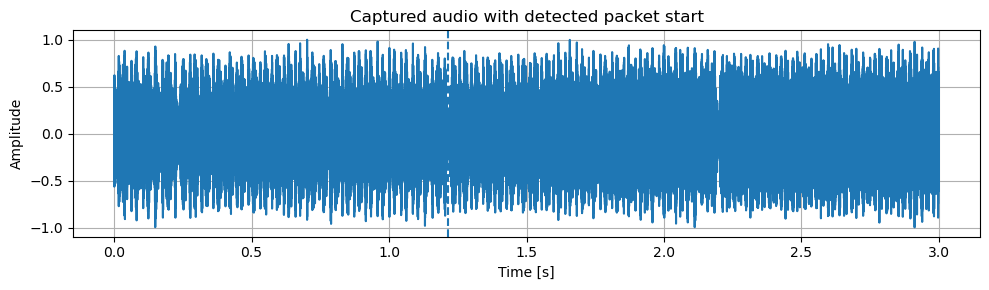

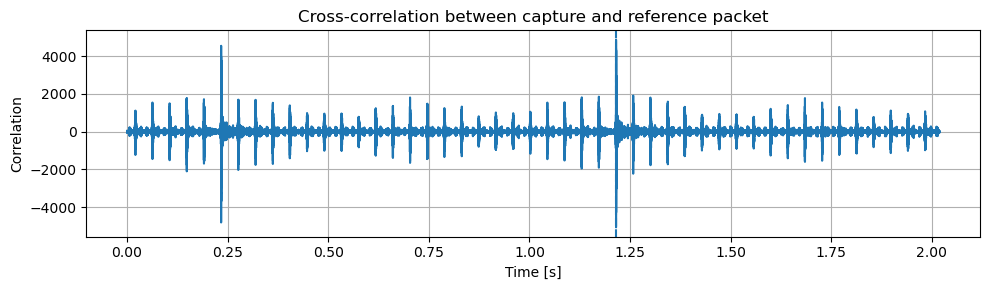

In [9]:
### plot 1
# === Plot A1: captured audio with packet location 
x = rx_audio.astype(np.float32)
x = x / (np.max(np.abs(x)) + 1e-9)

t = np.arange(len(x)) / cfg.fs

plt.figure(figsize=(10, 3))
plt.plot(t, x)
plt.axvline(peak_idx / cfg.fs, linestyle='--')
plt.title("Captured audio with detected packet start")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot A2: full cross-correlation with reference packet 
corr_full = np.correlate(x, audio_template, mode="valid")
tc = np.arange(len(corr_full)) / cfg.fs

plt.figure(figsize=(10, 3))
plt.plot(tc, corr_full)
plt.axvline(peak_idx / cfg.fs, linestyle='--')
plt.title("Cross-correlation between capture and reference packet")
plt.xlabel("Time [s]")
plt.ylabel("Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()


FFT peak bin index: 2


C:\Users\96653\AppData\Local\Temp\ipykernel_26268\2222659001.py:33: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(M), mag, use_line_collection=True)


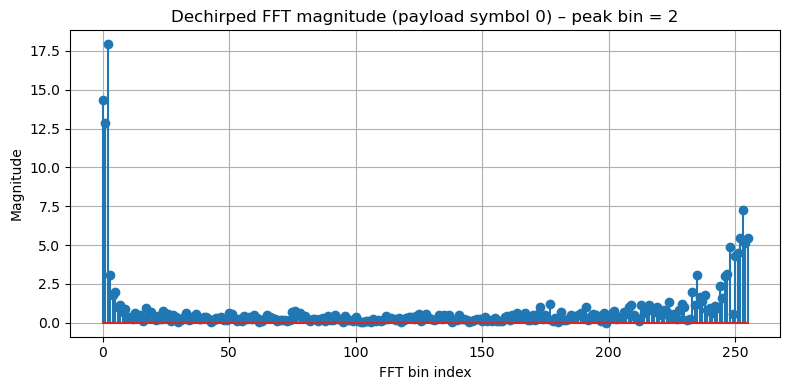

In [10]:
### Plot 2

# Parameters
Ns   = cfg.samples_per_symbol()
M    = cfg.m()
preN = cfg.preamble_symbols

# Baseband IQ for the whole recording
iq_bb = audio_to_iq_baseband(cfg, rx_audio)

# Take the first PAYLOAD symbol (skip preamble and 2 sync symbols)
sym_index = preN + 2   # 0-based index in the whole packet
sym_start = peak_idx + sym_index * Ns
sym_end   = sym_start + Ns

blk = iq_bb[sym_start:sym_end]

# Dechirp and downsample to M points
ref_up = make_upchirp(cfg)
OSR = Ns // M

dechirped = blk * np.conj(ref_up)
dechirped_reshaped = dechirped.reshape(M, OSR)
dechirped_dec = dechirped_reshaped.mean(axis=1)

spec = np.fft.fft(dechirped_dec)
mag  = np.abs(spec)
k_max = int(np.argmax(mag))

print("FFT peak bin index:", k_max)

plt.figure(figsize=(8, 4))
plt.stem(range(M), mag, use_line_collection=True)
plt.title(f"Dechirped FFT magnitude (payload symbol {sym_index - (preN+2)}) – peak bin = {k_max}")
plt.xlabel("FFT bin index")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()


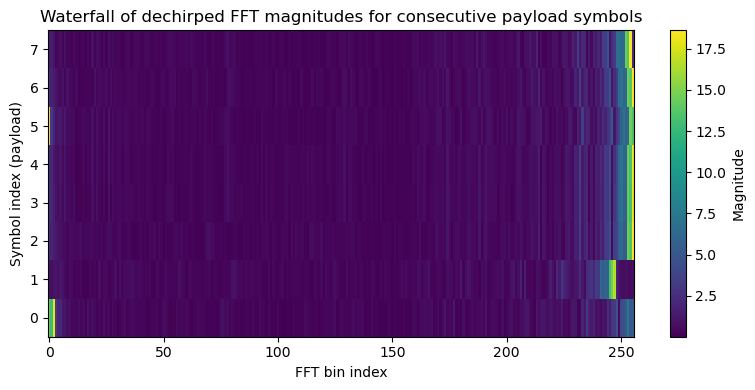

In [11]:
### Plot 3
# Number of consecutive symbols to visualize (starting from first payload symbol)
N_VIEW = 8

Ns   = cfg.samples_per_symbol()
M    = cfg.m()
preN = cfg.preamble_symbols

iq_bb = audio_to_iq_baseband(cfg, rx_audio)
ref_up = make_upchirp(cfg)
OSR = Ns // M

start_sym = preN + 2  # first payload symbol
syms_fft = []

for s_idx in range(start_sym, start_sym + N_VIEW):
    s_start = peak_idx + s_idx * Ns
    s_end   = s_start + Ns
    blk = iq_bb[s_start:s_end]

    dechirped = blk * np.conj(ref_up)
    dechirped_reshaped = dechirped.reshape(M, OSR)
    dechirped_dec = dechirped_reshaped.mean(axis=1)

    spec = np.fft.fft(dechirped_dec)
    mag  = np.abs(spec)
    syms_fft.append(mag)

syms_fft = np.array(syms_fft)  # shape: (N_VIEW, M)

plt.figure(figsize=(8, 4))
plt.imshow(
    syms_fft,
    aspect='auto',
    origin='lower',
    interpolation='nearest'
)
plt.colorbar(label="Magnitude")
plt.xlabel("FFT bin index")
plt.ylabel("Symbol index (payload)")
plt.title("Waterfall of dechirped FFT magnitudes for consecutive payload symbols")
plt.tight_layout()
plt.show()
